## Object Detection with RetinaNet

### Setup

In [ ]:
import os
import re
import zipfile
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, datasets
import torchvision.ops.boxes as nms_ops

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Downloading the COCO2017 dataset

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

In [ ]:
os.makedirs("data")

with zipfile.ZipFile("coco_train2017.zip", "r") as z_fp:
    z_fp.extractall("./data/")

with zipfile.ZipFile("coco_val2017.zip", "r") as z_fp:
    z_fp.extractall("./data/")

with zipfile.ZipFile("coco_ann2017.zip", "r") as z_fp:
    z_fp.extractall("./data/")

### Dataset


In [ ]:
class CocoDataset(Dataset):
    def __init__(self, image_path, annotation_path, image_size=(200,200), transform=None, random_state=42):
        self.transform = transform
        self.image_size = image_size

        self.images_path = sorted(glob(image_path + "/*.jpg"))
        self.parse_annotations(annotation_path)
        self.targets = self.get_targets()

        random.Random(random_state).shuffle(self.images_path)
        random.Random(random_state).shuffle(self.targets)

    def parse_annotations(self, annotation_path):
        with open(annotation_path, 'r') as f:
            coco = json.load(f)
        self.annotations = defaultdict(list)
        self.images = {}
        self.categories = {}
        for ann in coco['annotations']:
            self.annotations[ann['image_id']].append(ann)
        for img in coco['images']:
            self.images[img['id']] = img
        for cat in coco['categories']:
            self.categories[cat['id']] = cat

    def image_read(self, path, size):
        im = Image.open(path).convert("RGB")
        im = im.resize(size)
        return np.array(im)

    def get_targets(self):
        targets = []
        for image_path in self.images_path:
            image_id = int(image_path.split("/")[-1].split(".")[0])
            annotation = self.annotations[image_id]
            targets.append([item["bbox"] + [item["category_id"]] for item in annotation])
        return targets

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        image = self.image_read(image_path, self.image_size)
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        target = torch.tensor(target)
        return image.float(), target.float()

### Creating datasets

In [ ]:
train_path = "data/train2017"
val_path = "data/val2017"
train_annotations = "data/annotations/instances_train2017.json"
val_annotations = "data/annotations/instances_val2017.json"

train_dataset = datasets.CocoDetection(root=train_path, annFile=train_annotations)
val_dataset = datasets.CocoDetection(root = val_path, annFile = val_annotations)

### Implementing utility functions

In [ ]:
def swap_xy(boxes):
    return torch.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], dim=-1)

def convert_to_xywh(boxes):
    return torch.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        dim=-1,
    )

def convert_to_corners(boxes):
    return torch.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        dim=-1,
    )

### Computing pairwise Intersection Over Union (IOU)

In [ ]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = torch.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = torch.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = torch.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = torch.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return torch.clip(intersection_area / union_area, 0.0, 1.0)

def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

### Implementing Anchor generator

In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = torch.tensor([x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]])
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = torch.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = torch.reshape(
                    torch.stack([anchor_width, anchor_height], dim=-1), (1, 1, 2)
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(torch.stack(anchor_dims, dim=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = torch.range(feature_width, dtype=torch.float32) + 0.5
        ry = torch.range(feature_height, dtype=torch.float32) + 0.5
        centers = torch.stack(torch.meshgrid(rx, ry), dim=-1) * self._strides[level - 3]
        centers = torch.unsqueeze(centers, dim=-2)
        centers = torch.tile(centers, (1, 1, self._num_anchors, 1))
        dims = torch.tile(
            self._anchor_dims[level - 3], (feature_height, feature_width, 1, 1)
        )
        anchors = torch.concat([centers, dims], dim=-1)
        return torch.reshape(
            anchors, (feature_height * feature_width * self._num_anchors, 4)
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                torch.ceil(image_height / 2 ** i),
                torch.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return torch.concat(anchors, dim=0)

### Preprocessing data

In [ ]:
def random_flip_horizontal(image, boxes):
    if torch.rand(()) > 0.5:
        image = torch.flip(image, dims=[1])
        boxes = torch.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], dim=-1
        )
    return image, boxes

def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    image_shape = image.shape[1:].type(torch.float32)
    if jitter is not None:
        min_side = torch.rand((), dtype=torch.float32).uniform_(jitter[0], jitter[1])
    ratio = min_side / torch.min(image_shape)
    if ratio * torch.max(image_shape) > max_side:
        ratio = max_side / torch.max(image_shape)
    image_shape = ratio * image_shape
    image = transforms.Resize(size=image_shape.type(torch.int32))(image)
    padded_image_shape = (torch.ceil(image_shape / stride) * stride).type(torch.int32)
    horizontal_padding = (padded_image_shape[1] - image_shape[1])/2
    vertical_padding = (padded_image_shape[0] - image_shape[0])/2
    image = transforms.Pad((horizontal_padding, vertical_padding))(image)
    return image, image_shape, ratio

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = (sample["objects"]["label"]).type(torch.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = torch.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        dim=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

### Encoding labels

In [ ]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor([0.1, 0.1, 0.2, 0.2], dtype=torch.float32)

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou, _ = torch.max(iou_matrix, dim=1)
        matched_gt_idx = torch.argmax(iou_matrix, dim=1)
        positive_mask = torch.ge(max_iou, match_iou)
        negative_mask = torch.lt(max_iou, ignore_iou)
        ignore_mask = torch.logical_not(torch.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            positive_mask.type(torch.float32),
            ignore_mask.type(torch.float32),
        )


    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = torch.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                torch.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            dim=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = cls_ids.type(torch.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = torch.index_select(gt_boxes, index=matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = torch.index_select(cls_ids, index=matched_gt_idx)
        cls_target = torch.where(
            torch.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = torch.where(torch.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = torch.unsqueeze(cls_target, dim=-1)
        label = torch.concat([box_target, cls_target], dim=-1)
        return label



    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = batch_images.shape
        batch_size = images_shape[0]

        labels = []
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels.append(label.type(torch.float32))
        batch_images = torchvision.models.ResNet50_Weights.IMAGENET1K_V1.transforms(batch_images)
        return batch_images, torch.stack(labels)

### RetinaNet Architecture

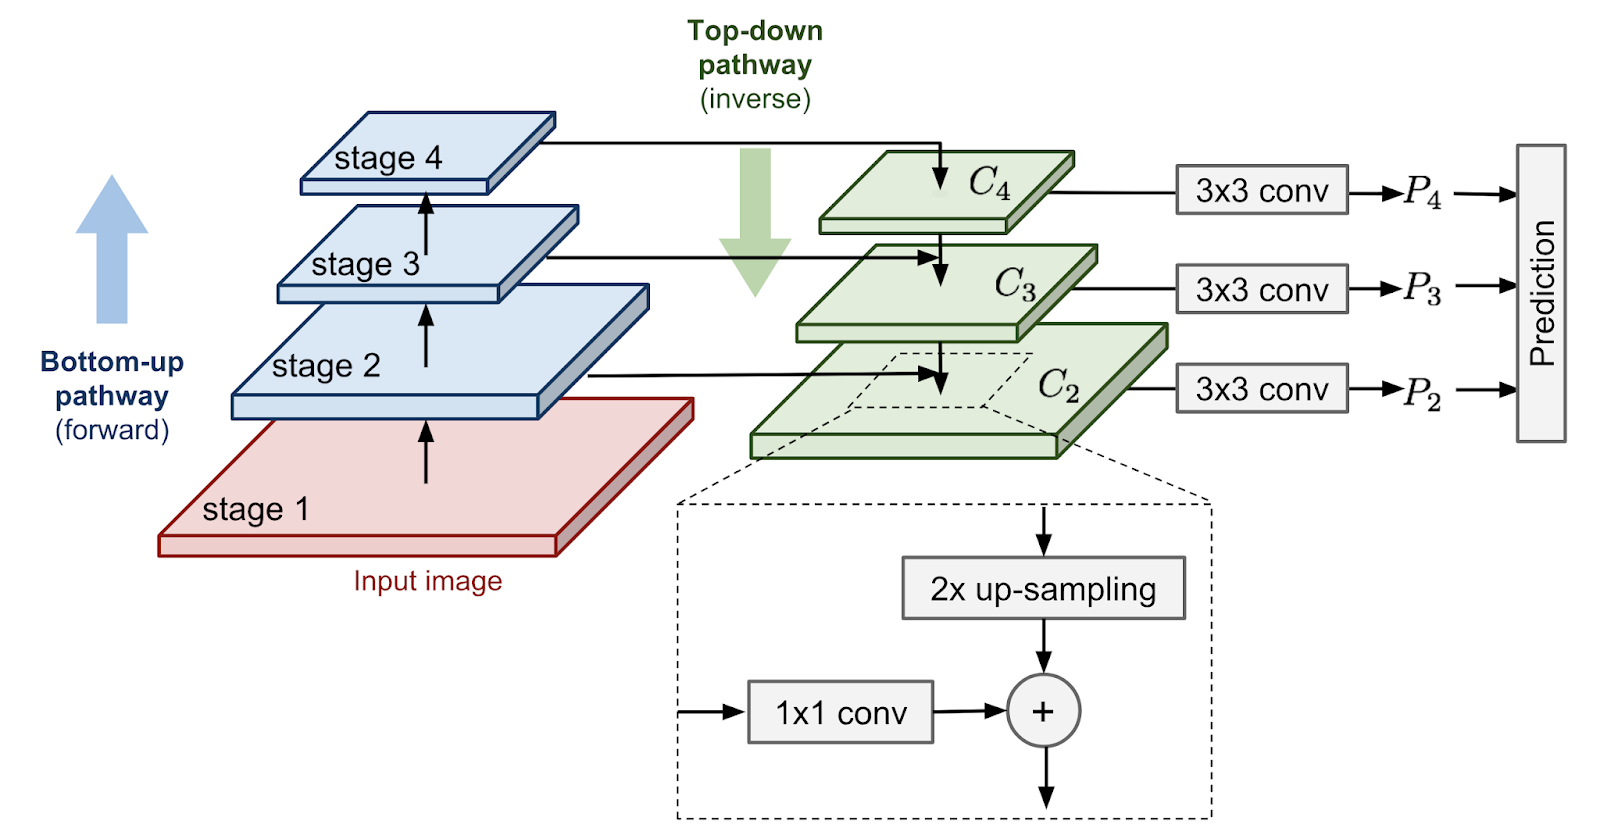

### Building the ResNet50 backbone

In [ ]:
class Backbone(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        backbone = torchvision.models.resnet50(weights="IMAGENET1K_V1")
        for model in backbone.modules():
            for parameter in model.parameters():
                parameter.requires_grad = False
        self.backbone = torch.nn.ModuleDict(list(backbone.named_children())[:-2])

    def forward(self, x):
        for model in self.backbone[-3]:
            x = model(x)
        stage2_output = self.backbone.layer2(x)
        stage3_output = self.backbone.layer3(stage2_output)
        stage4_output = self.backbone.layer4(stage3_output)
        return stage2_output, stage3_output, stage4_output

### Building Feature Pyramid Network

In [ ]:
class FeaturePyramid(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.backbone = Backbone()
        self.c2_1x1 =  nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1)
        self.c2_3x3 =  nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)
        self.c3_1x1 =  nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1)
        self.c3_3x3 =  nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1)
        self.c4_1x1 =  nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=1)
        self.c4_3x3 =  nn.Conv2d(in_channels=2048, out_channels=256, kernel_size=3, padding=1)
        self.c5_3x3 =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.c6_3x3 =  nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.upsample_2x = nn.Upsample(2)

    def forward(self, x):
        stage2_output, stage3_output, stage4_output = self.backbone(x)

        p2_output = self.c2_1x1(stage2_output)
        p3_output = self.c3_1x1(stage3_output)
        p4_output = self.c4_1x1(stage4_output)

        p3_output = p3_output + self.upsample_2x(p4_output)
        p2_output = p2_output + self.upsample_2x(p3_output)

        p2_output = self.c2_3x3(p2_output)
        p3_output = self.c3_3x3(p3_output)
        p4_output = self.c4_3x3(p4_output)

        p5_output = self.c5_3x3(stage4_output)
        p6_output = self.c6_3x3(F.relu(p5_output))
        return p2_output, p3_output, p4_output, p5_output, p6_output

### Building the classification and box regression heads

In [ ]:
class Head(nn.Module):
    def __init__(self, out_channels:int, bias_init, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.head = nn.ModuleList()

        for _ in range(4):
            self.head.append(nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                nn.ReLU()))

        last_layer = nn.Conv2d(in_channels=256, out_channels=out_channels, kernel_size=3, padding=1)
        nn.init.constant_(last_layer.bias, val=bias_init)
        self.head.append(last_layer)

        self.head.apply(self.init_weight)

    def init_weight(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

    def forward(self, x):
        for model in self.head:
            x = model(x)
        return x

### Building RetinaNet

In [ ]:
class RetinaNet(nn.Module):
    def __init__(self, num_classes:int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        self.cls_head = Head(out_channels=9 * num_classes, bias_init=-np.log((1 - 0.01) / 0.01))
        self.box_head = Head(out_channels=9 * 4, bias_init=0)

    def forward(self, x):
        features = self.fpn(x)
        N = x.shape[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(torch.reshape(self.box_head(feature), (N, 4, -1)))
            cls_outputs.append(
                torch.reshape(self.cls_head(feature), (N, self.num_classes, -1))
            )
        cls_outputs = torch.concat(cls_outputs, dim=-1)
        box_outputs = torch.concat(box_outputs, dim=-1)
        return torch.concat([box_outputs, cls_outputs], dim=1)

### Implementing a custom module to decode predictions

In [ ]:
class DecodePredictions(nn.Module):
    def __init__(self, num_classes=80, confidence_threshold=0.05,
        nms_iou_threshold=0.5, max_detections_per_class=100,
        max_detections=100, box_variance=[0.1, 0.1, 0.2, 0.2],
        *args, **kwargs) -> None:

        super().__init__(*args, **kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = torch.tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=torch.float32
        )

        def _decode_box_predictions(self, anchor_boxes, box_predictions):
            boxes = box_predictions * self._box_variance
            boxes = torch.concat(
                [
                    boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                    torch.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
                ],
                dim=-1,
            )
            boxes_transformed = convert_to_corners(boxes)
            return boxes_transformed

        def _combined_non_max_suppression(self, boxes, scores, max_output_size_per_class, max_total_size, iou_threshold=0.5, score_threshold=0.5):
            selected_indices_list = []
            for class_scores in scores.split(1, dim=-1):
                class_scores = class_scores.squeeze(-1)
                mask = class_scores > score_threshold
                class_boxes = boxes[mask]
                class_scores = class_scores[mask]
                selected_indices = nms_ops.batched_nms(class_boxes, class_scores, torch.zeros_like(class_scores), iou_threshold)
                selected_indices_list.append(selected_indices)

            selected_indices_all = torch.cat(selected_indices_list, dim=0)

            if len(selected_indices_all) > max_total_size:
                selected_indices_all = selected_indices_all[:max_total_size]

            return selected_indices_all

        def forward(self, images, predictions):
            image_shape = (images.shape).type(torch.float32)
            anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
            box_predictions = predictions[:, :4, :]
            cls_predictions = F.sigmoid(predictions[:, 4:, :])
            boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

            return self._combined_non_max_suppression(
                torch.unsqueeze(boxes, dim=2),
                cls_predictions,
                self.max_detections_per_class,
                self.max_detections,
                self.nms_iou_threshold,
                self.confidence_threshold,
                clip_boxes=False,
            )

### Implementing Smooth L1 loss and Focal Loss

In [ ]:
class RetinaNetBoxLoss(nn.Module):
    def __init__(self, delta, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._delta = delta

    def forward(self, predictions, targets):
        difference = targets - predictions
        absolute_difference = torch.abs(difference)
        squared_difference = difference ** 2
        loss = torch.where(
            torch.lt(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return torch.sum(loss, dim=-1)

class RetinaNetClassificationLoss(nn.Module):
    def __init__(self, alpha, gamma, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._alpha = alpha
        self._gamma = gamma

    def forward(self, predictions, targets):
        cross_entropy = nn.BCEWithLogitsLoss()(predictions, targets)
        probs = F.sigmoid(predictions)
        alpha = torch.where(torch.equal(targets, 1.0), self._alpha, (1.0 - self._alpha))
        pt = torch.where(torch.equal(targets, 1.0), probs, 1 - probs)
        loss = alpha * torch.pow(1.0 - pt, self._gamma) * cross_entropy
        return torch.sum(loss, dim=-1)

class RetinaNetLoss(nn.Module):
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def forward(self, predictions, targets):
        predictions = predictions.type(torch.float32)
        box_labels = targets[:, :4, :]
        box_predictions = predictions[:, :4, :]
        cls_labels = F.one_hot(
            targets[:, 4, :].type(torch.int32),
            self._num_classes).type(torch.float32)
        cls_predictions = predictions[:, 4:, :]
        positive_mask = torch.gt(targets[:, 4, :], -1.0).type(torch.float32)
        ignore_mask = torch.equal(targets[:, 4, :], -2.0).type(torch.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = torch.where(torch.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = torch.where(torch.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = torch.sum(positive_mask, dim=1)
        clf_loss = torch.div(torch.sum(clf_loss, dim=1), normalizer if normalizer != 0 else torch.tensor(1e-7))
        box_loss = torch.div(torch.sum(box_loss, dim=1), normalizer if normalizer != 0 else torch.tensor(1e-7))
        loss = clf_loss + box_loss
        return loss

### Train

In [ ]:
class Train:
    def __init__(self, device, model, train_dataset, val_dataset, batch_size, criterion, optimizer, scheduler=None) -> None:
        self.device = device
        self.model = model.to(device)
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.creat_dataloader()

    def creat_dataloader(self, seed=42):
        torch.manual_seed(seed)
        self.train_dl = DataLoader(
            self.train_dataset, self.batch_size, shuffle=True)
        self.val_dl = DataLoader(self.val_dataset, self.batch_size)

    def run(self, num_epochs):
        self.best_loss = float('inf')
        self.patience_counter = 0

        train_losses = []
        test_losses = []

        for epoch in range(num_epochs):
            train_loss = self.train_epoch()
            train_losses.append(train_loss)

            test_loss = self.validate_epoch()
            test_losses.append(test_loss)

            if self.scheduler:
                scheduler.step()

            print(f"Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

            if self.early_stopping(test_loss):
                print(
                    f"Early stopping at epoch {epoch}, best accuracy {self.best_loss}")
                break

        return train_losses, test_losses

    def train_epoch(self):
        self.model.train()
        train_loss = 0.0

        for images, labels in tqdm(self.train_dl):
            print(labels.shape)
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = self.model(images)
            loss = self.criterion(output, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()

        train_loss /= len(self.train_dl)
        return train_loss

    @torch.no_grad()
    def validate_epoch(self):
        self.model.eval()
        test_loss = 0

        for images, labels in self.val_dl:
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = self.model(images)
            loss = self.criterion(output, labels)

            test_loss += loss.item()

        test_loss /= len(self.val_dl)
        return test_loss

    def early_stopping(self, test_loss, patience=5):
        if test_loss < self.best_loss:
            self.best_loss = test_loss
            self.patience_counter = 0
            torch.save(self.model.state_dict(), "best_model.pth")
        else:
            self.patience_counter += 1

        if self.patience_counter > patience:
            return True

        return False

### Setting up training parameters

In [ ]:
model_dir = "retinanet/"

num_classes = 80
batch_size = 2
momentum=0.9

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]

### Initializing and training the model

In [ ]:
label_encoder = LabelEncoder()
criterion = RetinaNetLoss(num_classes).to(device)
model = RetinaNet(num_classes).to(device)

def lr_lambda(step):
    for boundary, lr in zip(learning_rate_boundaries, learning_rates):
        if step < boundary:
            return lr
    return learning_rates[-1]

optimizer = optim.SGD(model.parameters(), learning_rates[0], momentum)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

train_model = Train(device, model, train_dataset, val_dataset, batch_size, criterion, optimizer, scheduler)

In [ ]:
train_model.run(1)